In [1]:
import numpy as np
import pandas as pd
import pickle as pkl 
import xarray as xr
import copy
import os
import sys 
import metrics
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
print("XArray version: ", xr.__version__)
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

XArray version:  0.16.1


In [2]:
##########################################################################################################
# LOAD IN THE DATA
##########################################################################################################
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb: 
    nwm_results = pkl.load(fb)

lstm_results_time_split1={}
mclstm_results_time_split1={}
sacsma_results_time_split1={}
lstm_results_time_split2={}
mclstm_results_time_split2={}
sacsma_results_time_split2={}

for forcing_type in ['nldas', 'daymet']:
    
    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split1[forcing_type] = pkl.load(fb)

    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split2[forcing_type] = pkl.load(fb)

train_split_type_model_set = {'time_split1':{'nwm':nwm_results, 
                                           'lstm':lstm_results_time_split1,
                                            'mc':mclstm_results_time_split1,
                                            'sac':sacsma_results_time_split1},
                              'time_split2':{'nwm':nwm_results,
                                           'lstm':lstm_results_time_split2,
                                            'mc':mclstm_results_time_split2,
                                            'sac':sacsma_results_time_split2}}

In [3]:
##########################################################################################################
# USE A CONVERSION BETWEEN MODELS AND DATA
##########################################################################################################
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [4]:
##########################################################################################################
# Get all the CAMELS attributes.  
##########################################################################################################

# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [5]:
##########################################################################################################
# Loop through all the SACSMA runs and check that the results are good. 
# Get a list of basins that has good calibration results.
##########################################################################################################
basin_list_all_camels = list(pd_attributes['basin_id_str'].values)
basin_list_sacsma_good = {ts:copy.deepcopy(basin_list_all_camels) for ts in ['time_split1', 'time_split2']}

for ib, basin_0str in enumerate(basin_list_all_camels): 
    remove_basin_id_from_list = False
    for train_split_type in ['time_split1', 'time_split2']:
        for forcing_type in ['nldas', 'daymet']:

            if basin_0str not in list(train_split_type_model_set[train_split_type]['sac'][forcing_type].columns):
                remove_basin_id_from_list = True
            elif train_split_type_model_set[train_split_type]['sac'][forcing_type][basin_0str].sum() <=0:
                remove_basin_id_from_list = True

            if train_split_type == 'time_split2' and forcing_type == 'nldas':
                if basin_0str not in list(train_split_type_model_set[train_split_type]['nwm'].keys()):
                    remove_basin_id_from_list = True

    if remove_basin_id_from_list:
        basin_list_sacsma_good[train_split_type].remove(basin_0str)

In [6]:
##########################################################################################################
#-------------------------------------------------------------------------------------------------
# Solve this problem. I think it is the xarray structures...
# isibleDeprecationWarning: Creating an ndarray from ragged nested sequences 
# (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
# If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
##########################################################################################################
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [7]:
##########################################################################################################
# REVERT TO THESE AS THE FLOWS
##########################################################################################################
flows = ['lstm', 'mc', 'sac', 'obs']


In [8]:
def get_specifications(tsplt, forcing_type):
    """
    This function is designed to return specific details of the simulation period
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    Returns
        start_date (pd.Timestamp): The date the simulation period started
        end_date (pd.Timestamp): The date the simulation period ended
        labelz (dictionary): A mapping between short model name and long model name
        models (list): the short model names
        flows (list): the short model names plus "obs" for observed flow
        basin_list (list): the list of basins that meet the criteria for analysis
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    """
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['nwm', 'lstm', 'mc', 'sac']
        flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    elif tsplt == 'time_split2':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    else:
        start_date = pd.Timestamp('1989-10-01')
        end_date = pd.Timestamp('1999-09-30')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split1[forcing_type].keys())[:-1]

    spex = {"start_date":start_date,
            "end_date":end_date,
            "labelz":labelz,
            "models":models,
            "flows":flows, 
            "basin_list":basin_list,
            "tsplt":tsplt,
            "forcing_type":forcing_type}
    return spex #(start_date, end_date, labelz, models, flows, basin_list)

In [9]:
def load_forcing_and_identify_events(tsplt, basin_0str, file_name_map, forcing_type):
    """
    This function loads in the forcing, and also identifies the indices of precipitation "events"
    Events are arbitrarily defined as any time the precipitation is greater than the median (non zero) precip
    
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        basin_0str (str): The basin ID as a string with a leading zero
        forcing_dir (str): The directory where to find the forcing file
        file_name_map (dictionary): 
        forcing_type (str): either nldas or daymet
    Return:
        forcing (pd.DataFrame): The forcing data for a particular basin
        precip_events (list): Indices of official precipitation "events"
    """
    
    forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
        f'/basin_mean_forcing/{forcing_type}_all_basins_in_one_directory/'
    
    basin_int = int(basin_0str)
    #-------------------------------------------------------------------------------------------------
    # FORCING
    forcing = pd.read_csv(f'{forcing_dir}{basin_0str}_lump_{file_name_map[forcing_type]}_forcing_leap.txt',
                          delim_whitespace=True, header=3)
    if tsplt == 'time_split1':
        forcing = forcing.iloc[3560:7214]
    if tsplt == 'time_split2':
        forcing = forcing.iloc[6118:]
    forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
    #-------------------------------------------------------------------------------------------------
    
    precip_threshold_50 = 0
    
    f_label = precip_column_map[forcing_type]

    any_precip = forcing[f_label][forcing[f_label]>0].values
    any_precip.sort()
    onethrough = np.array([i for i in range(any_precip.shape[0])])/any_precip.shape[0]
    for i in range(any_precip.shape[0]):
        if onethrough[i] > .5:
            precip_threshold_50 = any_precip[i]
            break
            
    precip_events=[]
    # Get indices of precipitation events that have no such event two days prior, nor three days after
    for i, precip in enumerate(forcing[f_label]):
        if i < 3 or i > (forcing[f_label].shape[0]-3):
            continue
        if precip > precip_threshold_50:
            if np.sum(forcing[f_label][i-3:i]) < precip_threshold_50:
                if np.sum(forcing[f_label][i+1:i+5]) < precip_threshold_50:
                    precip_events.append(i)
                
#    print("Number of precipitation events", len(precip_events))
    
    return forcing, precip_events

In [10]:
def get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date):
    #-------------------------------------------------------------------------------------------------
    # Make dictionary with all the flows
    flow_mm = {}
    #-------------------------------------------------------------------------------------------------
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values,
                 coords=[nwm_results[basin_0str]['streamflow'].index],
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        xrr = xr_nwm.loc[start_date:end_date]*3600*24/(basin_area*1000)
        flow_mm['nwm'] = pd.DataFrame(data=xrr.values)
    #-------------------------------------------------------------------------------------------------
    # Standard LSTM 
    if tsplt == 'time_split1':
        xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # Mass-conserving LSTM data trained on all years
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # SACSMA Mean
    if tsplt == 'time_split1':
        df = sacsma_results_time_split1[forcing_type][basin_0str].loc[start_date:end_date]
    if tsplt == 'time_split2':
        df = sacsma_results_time_split2[forcing_type][basin_0str].loc[start_date:end_date]
    flow_mm['sac'] = df
    #-------------------------------------------------------------------------------------------------
    # OBSERVATIONS
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)

    #-------------------------------------------------------------------------------------------------
    # Make sure we are in a time period that all the flow members have values
    # If there is missin observations than we can't compare the mass of the observed with simulaitons
    skip_basin_because_missing_obs = False
    if tsplt == 'time_split1':
        obs_temp = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].datetime
    if tsplt == 'time_split2':
        obs_temp = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date
        
    return flow_mm, obs_temp


In [11]:
def calculate_mass_balance_over_events(basin_0str, spex, forcing, precip_events):
    
    basin_int = int(basin_0str)
    start_date = spex["start_date"]
    end_date = spex["end_date"]
    tsplt = spex["tsplt"]
    models = spex['models']
    flows = spex['flows']
    forcing_type = spex['forcing_type']
    
    mass_balance_over_events = pd.DataFrame(columns=["event",
                                                     "event_date",
                                                     "total_precip", 
                                                     "total_obs", 
                                                     "total_lstm",
                                                     "total_mc",
                                                     "total_sac",
                                                     "runoff_ratio",
                                                     "AME_lstm",
                                                     "PME_lstm",
                                                     "NME_lstm",
                                                     "RR_lstm",
                                                     "AME_mc",
                                                     "PME_mc",
                                                     "NME_mc",
                                                     "RR_mc",
                                                     "AME_sac",
                                                     "PME_sac",
                                                     "NME_sac",
                                                     "RR_sac"])
    if "nwm" in models:
        mass_balance_over_events["total_nwm"] = np.nan
        mass_balance_over_events["AME_nwm"] = np.nan
        mass_balance_over_events["PME_nwm"] = np.nan
        mass_balance_over_events["NME_nwm"] = np.nan
        mass_balance_over_events["RR_nwm"] = np.nan
    
    #-------------------------------------------------------------------------------------------------
#     # Reset the total mass to zero for this basin    
#     cumulative_mass = {event:{flow:[0] for flow in flows} for event in precip_events}
#     for event in precip_events:
#         cumulative_mass[event]['precip'] = [0]
    total_mass[forcing_type][tsplt][basin_0str] = {event:{flow:0 for flow in flows} for event in precip_events}
    #-------------------------------------------------------------------------------------------------


    #-------------------------------------------------------------------------------------------------
    # We need the basin area to convert to CFS, to interpolate the RI from LPIII
    basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
    basin_str = str(basin_int).zfill(8)
    #-------------------------------------------------------------------------------------------------

    
    
    #-------------------------------------------------------------------------------------------------    
    flow_mm, obs_temp = get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date)
    #-------------------------------------------------------------------------------------------------

                
        
    #-------------------------------------------------------------------------------------------------
    #################    DO MASS PER EVENT
    #-------------------------------------------------------------------------------------------------

    for event in precip_events:
        
        mass_balance_over_events.loc[event,'event'] = event
        
        sevd = event-3# StartEventDate
        eevd = event+5# EndEventDate
        
        for flow in flows:
            
            _flow = np.array(flow_mm[flow].iloc[sevd:eevd])
            total_mass[forcing_type][tsplt][basin_0str][event][flow] = np.sum(_flow)
                        
        ts = pd.to_datetime(str(forcing[precip_column_map[forcing_type]].index.values[event])) 
        d = ts.strftime('%Y.%m.%d')
        mass_balance_over_events.loc[event,'event_date'] = d

        _precip = np.sum(forcing[precip_column_map[forcing_type]].values[sevd:eevd])
        mass_balance_over_events.loc[event,'total_precip'] = _precip
        
        mass_balance_over_events.loc[event,'total_obs'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['obs']
        
        mass_balance_over_events.loc[event,'total_lstm'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['lstm']
        mass_balance_over_events.loc[event,'total_mc'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['mc']
        mass_balance_over_events.loc[event,'total_sac'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['sac']
        mass_balance_over_events.loc[event,'runoff_ratio'] = \
            mass_balance_over_events.loc[event,'total_obs'] / \
            mass_balance_over_events.loc[event,'total_precip']
        if "nwm" in models:
            mass_balance_over_events.loc[event,'total_nwm'] = \
                total_mass[forcing_type][tsplt][basin_0str][event]['nwm']


        for model in models:
            
            _obs = total_mass[forcing_type][tsplt][basin_0str][event]['obs']
            if _obs == 0:
                break
            _sim = total_mass[forcing_type][tsplt][basin_0str][event][model]
            
            mass_balance_over_events.loc[event,f'AME_{model}'] = np.abs(_sim - _obs) / _obs
            if (_sim - _obs) > 0:
                mass_balance_over_events.loc[event,f'PME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'NME_{model}'] = 0
            else:
                mass_balance_over_events.loc[event,f'NME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'PME_{model}'] = 0
                
            mass_balance_over_events.loc[event,f'RR_{model}'] = _sim / _precip

    return mass_balance_over_events



In [12]:
def scatter_plot_of_rr_events_for_basin(nldas, daymet, basin_0str, spex, plot_bounds=[0,2]):
    plt.scatter(nldas.runoff_ratio, nldas.RR_lstm, label="NLDAS lstm", c=colz[0])
    plt.scatter(nldas.runoff_ratio, nldas.RR_mc, label="NLDAS mc-lstm", c=colz[1])
    plt.scatter(nldas.runoff_ratio, nldas.RR_sac, label="NLDAS sac-sma", c=colz[2])
    plt.scatter(daymet.runoff_ratio, daymet.RR_lstm, marker="x", label="Daymet lstm", c=colz[0])
    plt.scatter(daymet.runoff_ratio, daymet.RR_mc, marker="x", label="Daymet mc-lstm", c=colz[1])
    plt.scatter(daymet.runoff_ratio, daymet.RR_sac, marker="x", label="Daymet sac-sma", c=colz[2])
    plt.title(f"runoff ratio at basin {basin_0str}")
    plt.xlabel("observed")
    plt.ylabel("simulated")
    plt.xlim(plot_bounds)
    plt.ylim(plot_bounds)
    plt.legend()
    plt.show()
    plt.close()

In [13]:
forcing_products = ['nldas','daymet']
file_name_map = {'nldas':'nldas', 'daymet':'cida'}
precip_column_map = {'nldas':'PRCP(mm/day)', 'daymet':'prcp(mm/day)'}

In [14]:
if True:
    with open("event_results.pkl", "rb") as fb:
        events_results = pkl.load(fb)
else:
    ##########################################################################################################
    # IDENTIFY EVENTS WITH PRECIP OVER 10mm
    # THEN DO THE MASS BALANCE CALC OVER SOME WINDOW
    ##########################################################################################################

    total_mass = {forcing_type:{time_split:{} for time_split in ['time_split1', 'time_split2']} for \
                           forcing_type in forcing_products}

    events_results = {tsplt: {forcing_type:{} for forcing_type in forcing_products} for \
                           tsplt in ['time_split1', 'time_split2']}

    for tsplt in ['time_split2', 'time_split1']:

        print('tsplt', tsplt)

        for forcing_type in forcing_products:

            print('forcing_type ',forcing_type)

            forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
                '/basin_mean_forcing/{}_all_basins_in_one_directory/'.format(forcing_type)

            spex = get_specifications(tsplt, forcing_type)

            for basin_0str in spex["basin_list"]:

    #            print(basin_0str)

                forcing, precip_events = load_forcing_and_identify_events(tsplt, 
                                                                          basin_0str, 
                                                                          forcing_dir, 
                                                                          file_name_map, 
                                                                          forcing_type)

                events_results[tsplt][forcing_type][basin_0str] = calculate_mass_balance_over_events(basin_0str, 
                                                                              spex, 
                                                                              forcing, 
                                                                              precip_events)
            
    with open("event_results.pkl", "wb") as fb:
        pkl.dump(events_results, fb)

In [15]:
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [16]:
print("Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)")

for tsplt in ['time_split1', 'time_split2']:
    
    spex = get_specifications(tsplt, 'nldas')
        
    rr_nldas_obs = []
    rr_nldas_lstm = []
    rr_nldas_mc = []
    rr_nldas_sac = []
    rr_daymet_obs = []
    rr_daymet_lstm = []
    rr_daymet_mc = []
    rr_daymet_sac = []
    
    if tsplt == 'time_split2':
        rr_nldas_nwm = []
    
    for i, basin_0str in enumerate(spex["basin_list"]):
        
        _nldas = events_results[tsplt]['nldas'][basin_0str].dropna()
        _daymet = events_results[tsplt]['daymet'][basin_0str].dropna()

        rr_nldas_obs.extend(list(_nldas.runoff_ratio))
        rr_daymet_obs.extend(list(_daymet.runoff_ratio))

        rr_nldas_lstm.extend(list(_nldas.RR_lstm))
        rr_nldas_mc.extend(list(_nldas.RR_mc))
        rr_nldas_sac.extend(list(_nldas.RR_sac))

        rr_daymet_lstm.extend(list(_daymet.RR_lstm))
        rr_daymet_mc.extend(list(_daymet.RR_mc))
        rr_daymet_sac.extend(list(_daymet.RR_sac))
        
        if tsplt == 'time_split2':
            rr_nldas_nwm.extend(list(_nldas.RR_nwm))
        
    print(f"For {tsplt}")
    print("Mutual information between observed and predicted Runoff Ratios")
    print(f"{len(rr_nldas_obs)} total events with NLDAS")
    print("NLDAS LSTM", np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3))
    print("NLDAS MC-LSTM", np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3))
    print("NLDAS Sac-SMA", np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3))
    if tsplt == 'time_split2':
        print("NLDAS NWM", np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3))
    print(f"{len(rr_daymet_obs)} total events with Daymet")
    print("Daymet LSTM", np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3))
    print("Daymet MC-LSTM", np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3))
    print("Daymet Sac-SMA", np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3))
    print(" ")

Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)
For time_split1
Mutual information between observed and predicted Runoff Ratios
23551 total events with NLDAS
NLDAS LSTM 0.564
NLDAS MC-LSTM 0.52
NLDAS Sac-SMA 0.436
44461 total events with Daymet
Daymet LSTM 0.83
Daymet MC-LSTM 0.723
Daymet Sac-SMA 0.48
 
For time_split2
Mutual information between observed and predicted Runoff Ratios
54465 total events with NLDAS
NLDAS LSTM 0.499
NLDAS MC-LSTM 0.513
NLDAS Sac-SMA 0.418
NLDAS NWM 0.447
70308 total events with Daymet
Daymet LSTM 0.732
Daymet MC-LSTM 0.71
Daymet Sac-SMA 0.472
 


LSTM absolute mass error 0.35 0.28
MC-LSTM absolute mass error 0.49 0.37
SacSMA absolute mass error 0.43 0.83


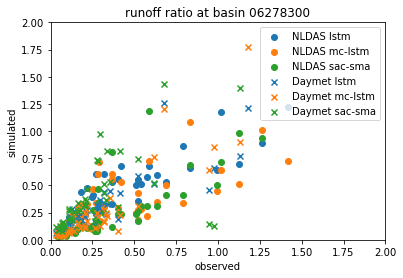

LSTM absolute mass error 0.26 0.23
MC-LSTM absolute mass error 0.38 0.3
SacSMA absolute mass error 0.53 1.57


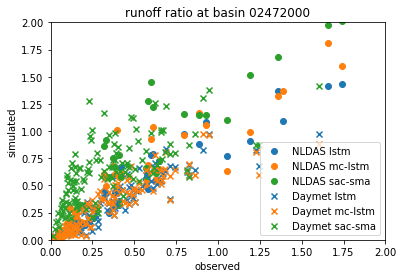

LSTM absolute mass error 0.41 0.34
MC-LSTM absolute mass error 0.39 0.29
SacSMA absolute mass error 0.68 1.52


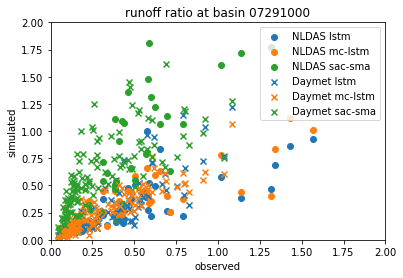

LSTM absolute mass error 0.3 0.26
MC-LSTM absolute mass error 0.29 0.27
SacSMA absolute mass error 0.26 0.28


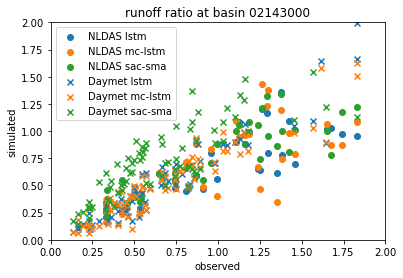

LSTM absolute mass error 0.21 0.24
MC-LSTM absolute mass error 0.19 0.45
SacSMA absolute mass error 0.3 0.5


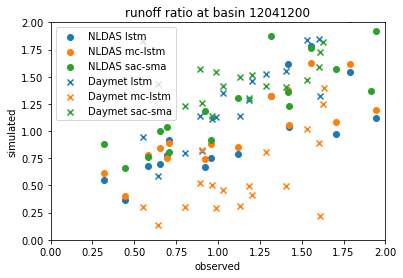

LSTM absolute mass error 0.36 0.59
MC-LSTM absolute mass error 0.27 0.41
SacSMA absolute mass error 0.72 0.78


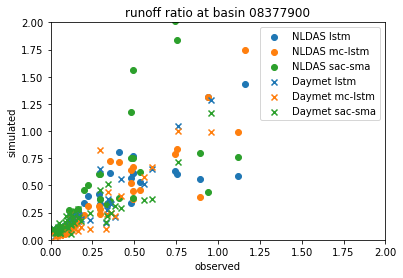

LSTM absolute mass error 16.15 4.63
MC-LSTM absolute mass error 15.44 8.2
SacSMA absolute mass error 21.54 21.35


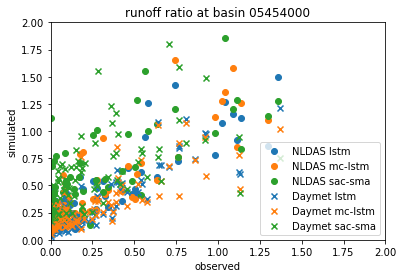

LSTM absolute mass error 0.31 0.38
MC-LSTM absolute mass error 0.5 0.47
SacSMA absolute mass error 0.46 1.11


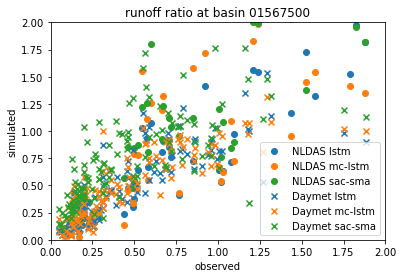

LSTM absolute mass error 0.22 0.16
MC-LSTM absolute mass error 0.32 0.22
SacSMA absolute mass error 0.22 0.33


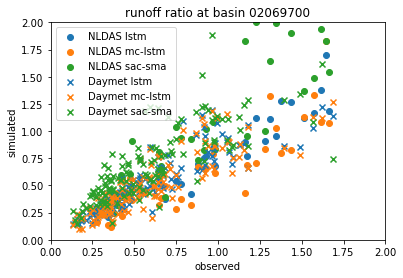

LSTM absolute mass error 58.04 8.59
MC-LSTM absolute mass error 27.72 6.02
SacSMA absolute mass error 195.18 26.95


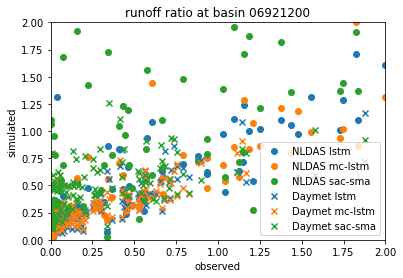

In [17]:
for i in [int(530 * np.random.rand()) for j in range(10)]:

    basin_0str = spex["basin_list"][i]
    
    _nldas = events_results['time_split1']['nldas'][basin_0str]
    _daymet = events_results['time_split1']['daymet'][basin_0str]

    print("LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_lstm']),2), 
                                      np.round(np.mean(_daymet.loc[:,'AME_lstm']),2))
    print("MC-LSTM absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_mc']),2),
                                         np.round(np.mean(_daymet.loc[:,'AME_mc']),2))
    print("SacSMA absolute mass error", np.round(np.mean(_nldas.loc[:,'AME_sac']),2),
                                        np.round(np.mean(_daymet.loc[:,'AME_sac']),2))

    scatter_plot_of_rr_events_for_basin(_nldas, _daymet, basin_0str, spex, plot_bounds=[0,2])
    

In [18]:
def plot_event_hydrograph(event, 
                              flow_mm_nldas, flow_mm_daymet, 
                              forcing_nldas, forcing_daymet):
        
    sevd = event-3# StartEventDate
    eevd = event+5# EndEventDate

    flow_obs_nldas = np.array(flow_mm_nldas['obs'].iloc[sevd:eevd])
    flow_obs_daymet = np.array(flow_mm_daymet['obs'].iloc[sevd:eevd])
    flow_lstm_nldas = np.array(flow_mm_nldas['lstm'].iloc[sevd:eevd])
    flow_lstm_daymet = np.array(flow_mm_daymet['lstm'].iloc[sevd:eevd])
    flow_mc_nldas = np.array(flow_mm_nldas['mc'].iloc[sevd:eevd])
    flow_mc_daymet = np.array(flow_mm_daymet['mc'].iloc[sevd:eevd])
    flow_sac_nldas = np.array(flow_mm_nldas['sac'].iloc[sevd:eevd])
    flow_sac_daymet = np.array(flow_mm_daymet['sac'].iloc[sevd:eevd])    
    precip_nldas = forcing_nldas[precip_column_map['nldas']].values[sevd:eevd]
    precip_daymet = forcing_daymet[precip_column_map['daymet']].values[sevd:eevd]

    plt.plot(flow_obs_nldas, label="obs nldas", c="cyan")
    plt.plot(flow_obs_daymet, '--', label="obs daymet", c="cyan")

    plt.plot(flow_lstm_nldas, label="lstm nldas", c=colz[0])
    plt.plot(flow_lstm_daymet, '--', label="lstm daymet", c=colz[0])
    plt.plot(flow_mc_nldas, label="MC-LSTM nldas", c=colz[1])
    plt.plot(flow_mc_daymet, '--', label="MC-LSTM daymet", c=colz[1])
    plt.plot(flow_sac_nldas, label="SAC-SMA nldas", c=colz[2])
    plt.plot(flow_sac_daymet, '--', label="SAC-SMA daymet", c=colz[2])
#     plt.plot(precip_nldas, label="precip nldas", c='k')
#     plt.plot(precip_daymet, label="precip daymet", c='k')
    plt.legend()
    plt.show()
    plt.close()

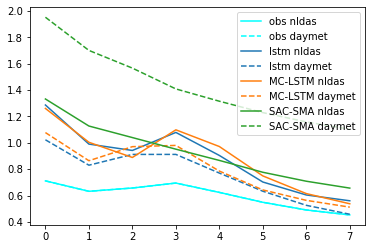

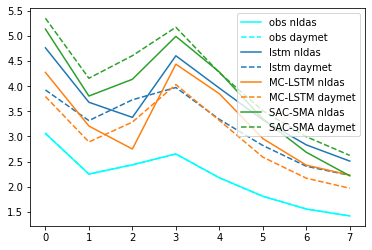

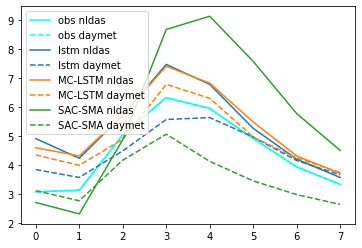

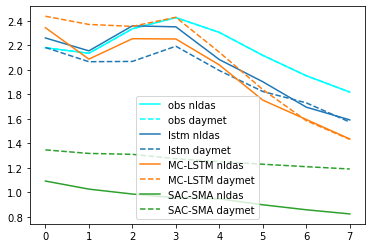

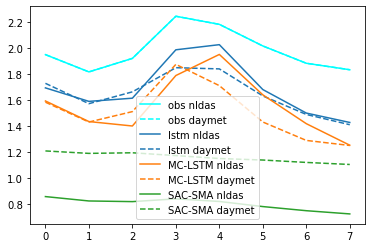

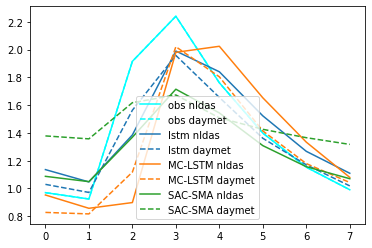

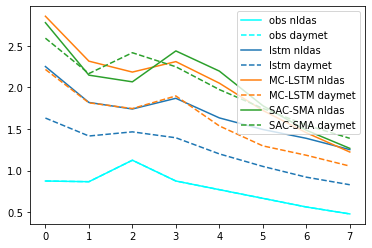

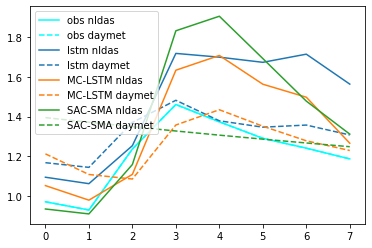

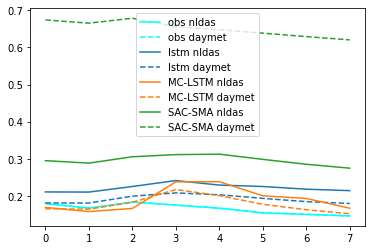

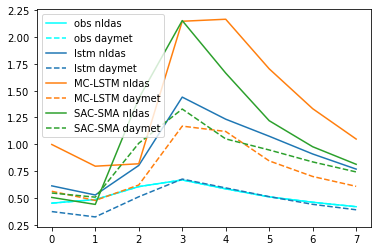

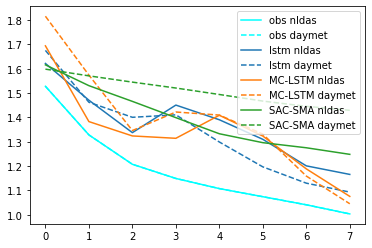

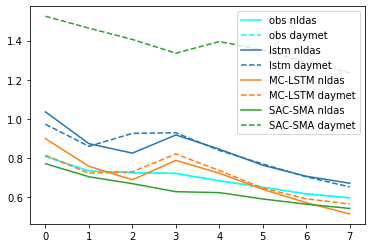

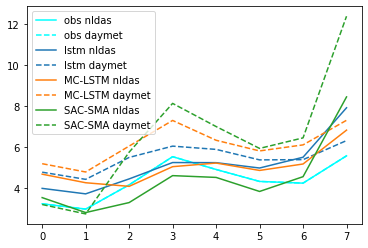

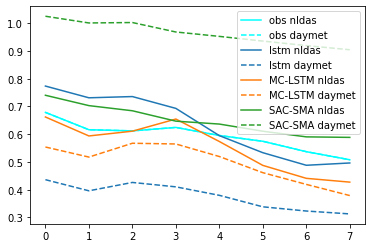

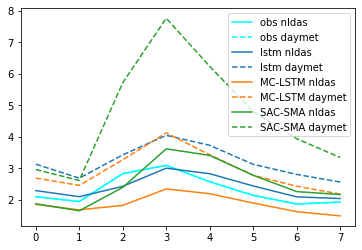

In [19]:
tsplt ='time_split1'

overlapping_events = {basin:[] for basin in spex["basin_list"]}
        
spex = get_specifications(tsplt, 'nldas')
start_date = spex['start_date']
end_date = spex['end_date']
    
for basin_0str in spex["basin_list"]:
        
    spex = get_specifications(tsplt, 'nldas')
    forcing_nldas, precip_events_nldas = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'nldas')

    spex = get_specifications(tsplt, 'daymet')
    forcing_daymet, precip_events_daymet = load_forcing_and_identify_events(tsplt, 
                                                              basin_0str, 
                                                              file_name_map, 
                                                              'daymet')
    
    for i in precip_events_nldas:
        if i in precip_events_daymet:
            overlapping_events[basin_0str].append(i)

            
    flow_mm_nldas, _ = get_precip_and_flows(tsplt, 
                                             'nldas', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)
    flow_mm_daymet, _ = get_precip_and_flows(tsplt, 
                                             'daymet', 
                                             basin_0str, 
                                             start_date, 
                                             end_date)    

    for event in overlapping_events[basin_0str]:
        plot_event_hydrograph(event, 
                              flow_mm_nldas, flow_mm_daymet, 
                              forcing_nldas, forcing_daymet)
    
    break